#### Dependencias

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import DMatrix, train, cv, plot_importance

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

#### Variables

In [3]:
DATAPATH = Path(os.getcwd()).parent / 'data'
SEED = 1399

#### Leer datos

In [4]:
df = pd.read_csv(DATAPATH / 'train.csv').drop('Id', axis=1)
print(f'Filas: {df.shape[0]:,}')
print(f'Columnas: {df.shape[1]:,}')
df.head(5)

Filas: 1,460
Columnas: 80


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Exploracion inicial de datos

In [5]:
df.dtypes.value_counts()

object     43
int64      34
float64     3
Name: count, dtype: int64

- Hay 43 variables de tipo guardadas como texto.
- Hay 37 variables de tipo numerico. De estas variables, 34 son enteros y 3 son flotantes.

In [6]:
(df.isna().sum()[df.isna().sum() > 0] * 100 / len(df)) \
    .sort_values(ascending=False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

- Hay 19 variables con valores faltantes.
- Las variables `PoolQC`, `MiscFeature`, `Alley` tienen mas del 90% de datos faltantes.
- La variable `Fence` tiene 80% de valores faltantes.
- La variable `MasVnrType` y `FireplaceQu` tienen aproximadamente la mitad de los datos faltantes.
- La variable `LotFrontage` tiene alrededor de 17% de datos faltantes.
- Las demas variables con valores faltantes (12) tienen un porcentaje menor al 6% de valores faltantes.

# Analisis Exploratorio de Datos

#### Target

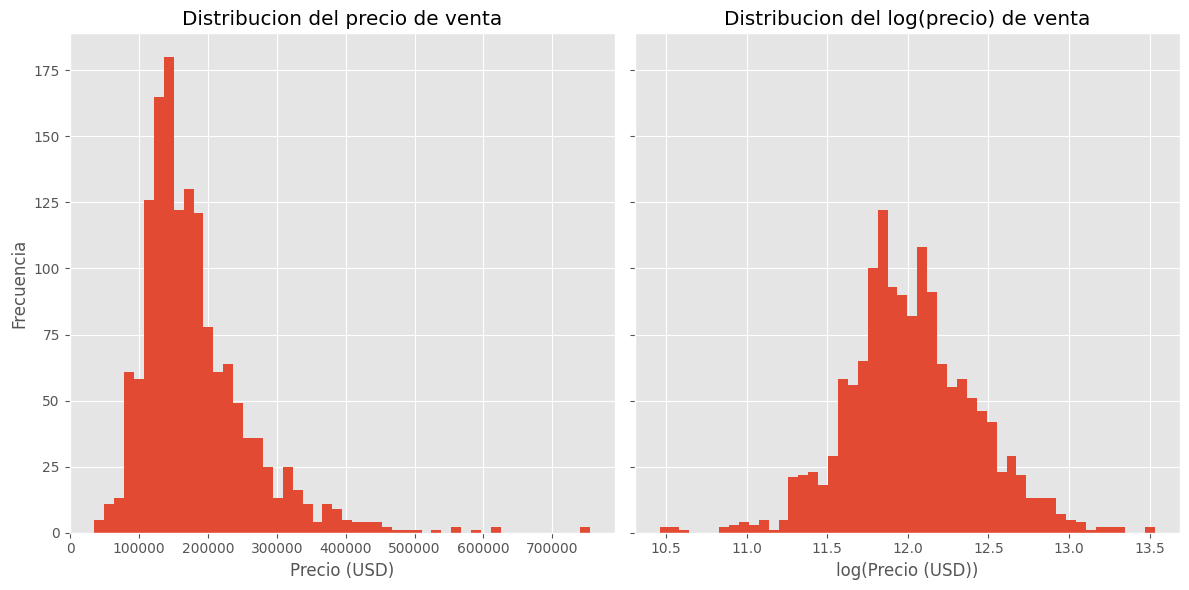

In [7]:
# Target
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
df['SalePrice'].plot(kind='hist', bins=50, title='Distribucion del precio de venta', xlabel='Precio (USD)', ylabel='Frecuencia', ax=ax[0])
np.log1p(df['SalePrice']).plot(kind='hist', bins=50, title='Distribucion del log(precio) de venta', xlabel='log(Precio (USD))', ylabel='Frecuencia', ax=ax[1])
fig.tight_layout()
plt.show()

Ahora, analizando los dos histogramas anteriores para medir la distribución del precio de la vivienda, podemos observar a partir del primer histograma, “Distribución del precio de venta”, que la variable tiene un sesgo hacia la izquierda. Esto significa que la mayoría de las viviendas tienen precios más bajos, con un número menor de viviendas con precios más altos. Algo habitual en el mercado inmobiliario dado la elasticidad precio/demanda de este tipo de bienes. Al ser un bien de lujo, mayores precios desestimula el nivel de la demanda, generando un agrupación importante alrededor de los precios más bajos, en línea con la distribución del ingreso que suele tener la economía estadounidense: la principal parte de la población se ubica en los quintiles de ingresos más bajos. Por otra parte, este tipo de distribución es común en situaciones donde no puedes tener valores negativos, como los precios de las viviendas. La cola larga hacia la derecha indica que hay algunas viviendas que son significativamente más caras que la mayoría.

El segundo histograma, “Distribución del log(precio) de venta”, parece ser más simétrico. Esto sugiere que tomar el logaritmo de los precios ha ayudado a normalizar la distribución. En otras palabras, el logaritmo reduce el efecto de los valores extremadamente altos (o bajos), haciendo que la distribución sea menos sesgada y más simétrica.

El sesgo en la distribución del precio de las viviendas puede deberse a varios factores. Por ejemplo, podría haber una gran cantidad de viviendas asequibles en el mercado, lo que empujaría la distribución hacia la izquierda. Alternativamente, podría haber algunas viviendas extremadamente caras que están empujando la cola de la distribución hacia la derecha.

## Variables Numericas

In [33]:
NUMERICAS = df.drop('SalePrice', axis=1).select_dtypes('number').columns.tolist()
print(len(NUMERICAS))

36


Así mismo, contamos con 36 variables numéricas, con las cuales no será necesario hacer transformaciones tipo dummies para incorporarlas en modelos de regresión, por ejemplo.

#### Estadisticas descriptivas

In [80]:
df[NUMERICAS].describe().T.round()

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,57.0,42.0,20.0,20.0,50.0,70.0,190.0
LotFrontage,1201.0,70.0,24.0,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,10517.0,9981.0,1300.0,7554.0,9478.0,11602.0,215245.0
OverallQual,1460.0,6.0,1.0,1.0,5.0,6.0,7.0,10.0
OverallCond,1460.0,6.0,1.0,1.0,5.0,5.0,6.0,9.0
YearBuilt,1460.0,1971.0,30.0,1872.0,1954.0,1973.0,2000.0,2010.0
YearRemodAdd,1460.0,1985.0,21.0,1950.0,1967.0,1994.0,2004.0,2010.0
MasVnrArea,1452.0,104.0,181.0,0.0,0.0,0.0,166.0,1600.0
BsmtFinSF1,1460.0,444.0,456.0,0.0,0.0,384.0,712.0,5644.0
BsmtFinSF2,1460.0,47.0,161.0,0.0,0.0,0.0,0.0,1474.0


#### Correlaciones

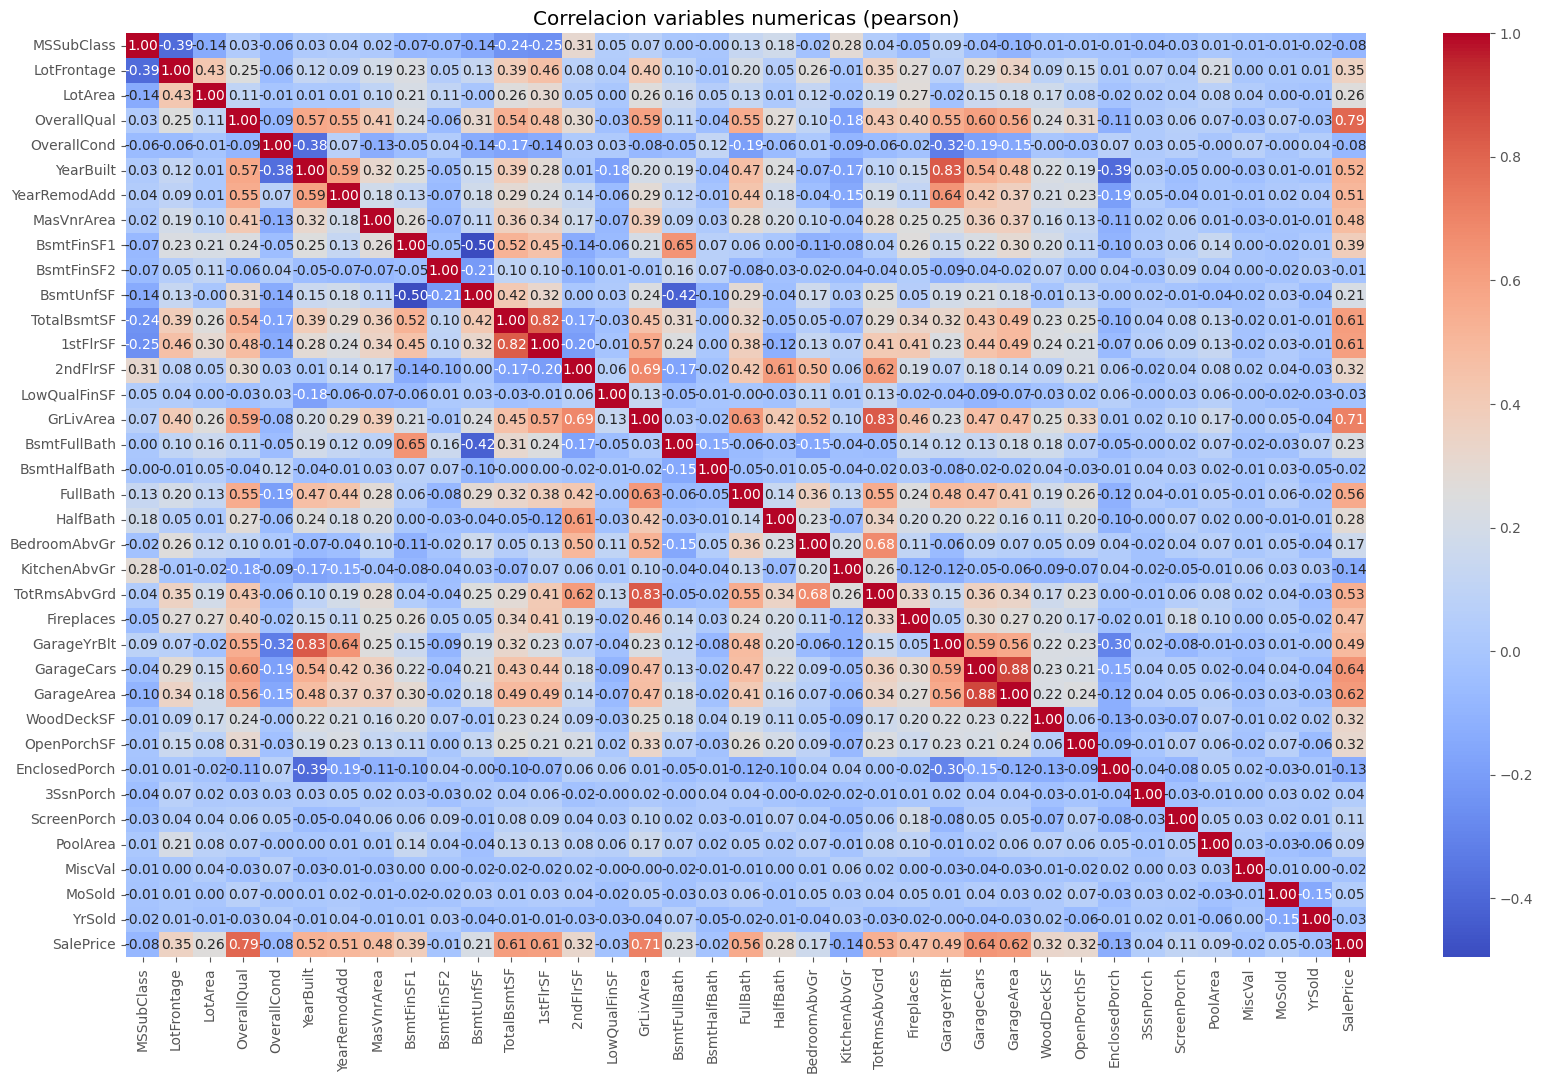

In [90]:
#### Correlacion lineal (pearson)
plt.figure(figsize=(20, 12))
corr = df[NUMERICAS + ['SalePrice']].corr(method='pearson')
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlacion variables numericas (pearson)')
plt.show()

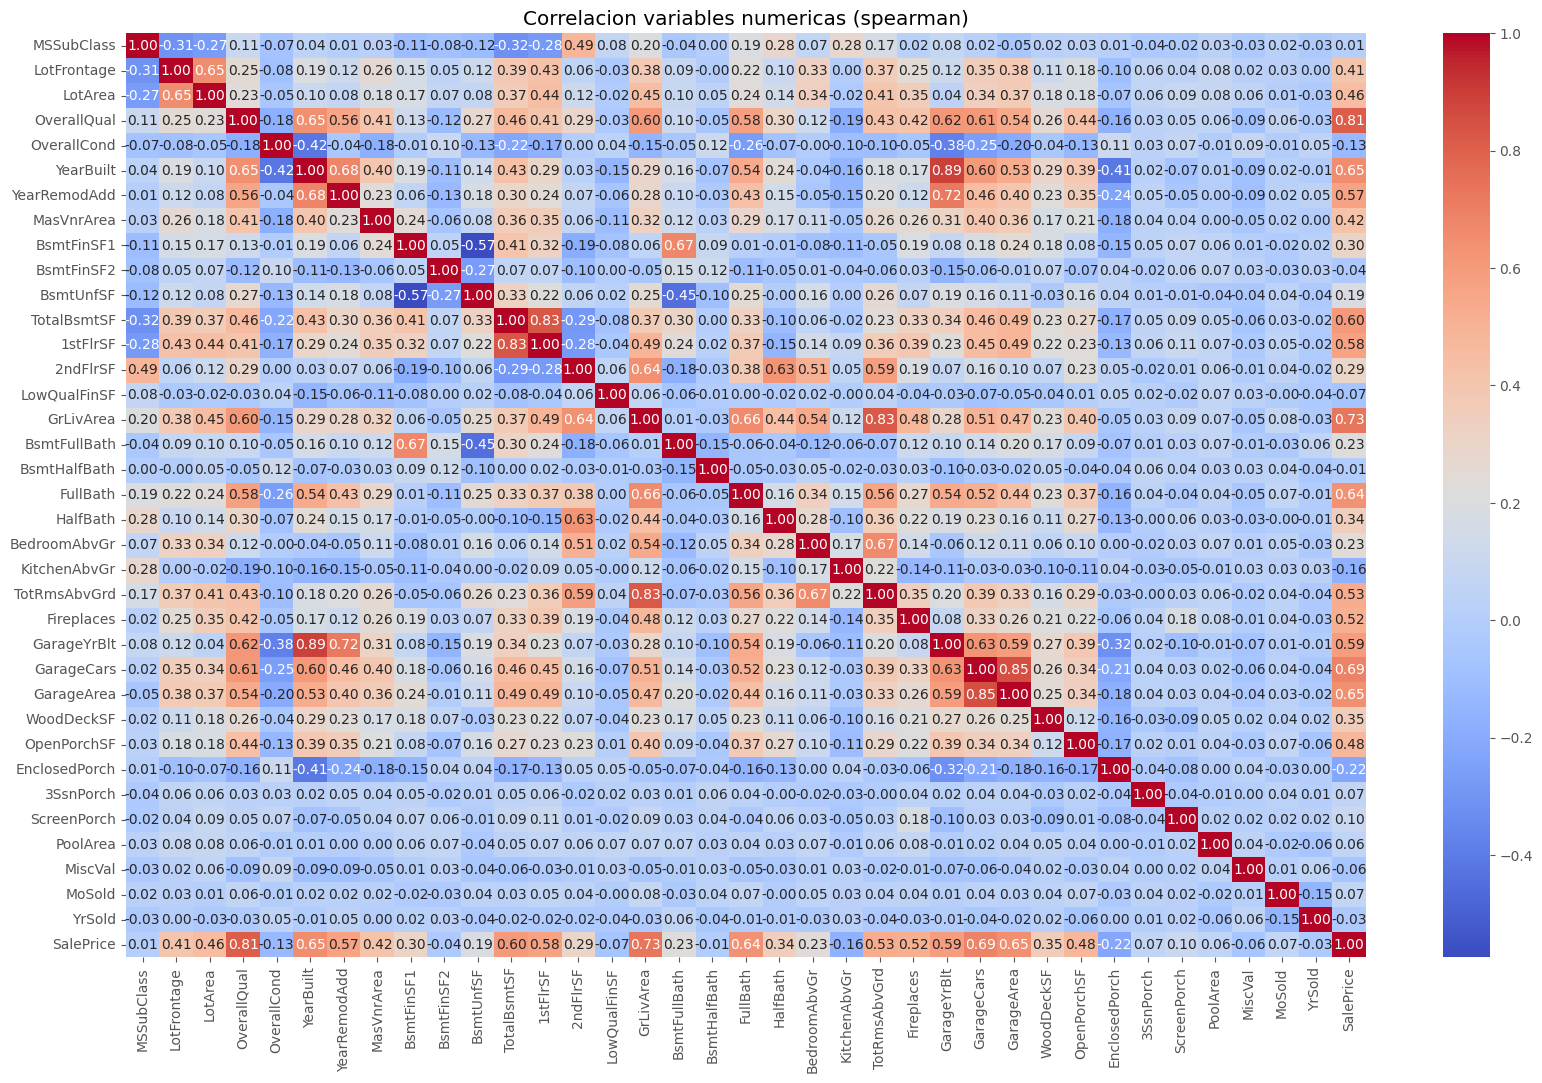

In [91]:
#### Correlacion monotona (spearman)
plt.figure(figsize=(20, 12))
corr = df[NUMERICAS + ['SalePrice']].corr(method='spearman')
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlacion variables numericas (spearman)')
plt.show()

Tanto a través de la correlación de Pearson, como la de Spearman, observamos ciertos patrones correlativos entre las variables numéricas. Por una parte, encontramos que cerca de 20 variables cuentan con una correlación importante con la variable endógena, el precio de la vivienda. Así que, a través de esta ilustración, podemos ir tomando en cuenta algunas candidatas a variables exógenas que se tendrán cuenta en los modelamientos. Sin embargo, también es necesario analizar correlaciones entre estas variables exógenas para evitar multicolinealidad y realizar oportunamente manejo a través de análisis de componentes principales o algún método para reducir la dimensionalidad de la matriz. 

Vemos algunas correlaciones importantes entre variables explicativas como sucede entre año de construcción del garaje y año de construcción de la vivienda, puesto que ambas variables suelen estar relacionadas con la antiguedad del inmueble. Por otra parte, existe una correlación alta entre año de construcción y año de remodelación del inmueble, donde ambas variables tratan de representar la antiguedad del inmueble y pueden transformarse para expresar la varianza explicada conjunta de este tipo de variables en una sola y limitar la multicolinealidad en el modelo. Así mismo, hay correlaciones importantes entre características que representan la calidad del inmueble como OverallCond y GrLivArea.

#### Distribucion

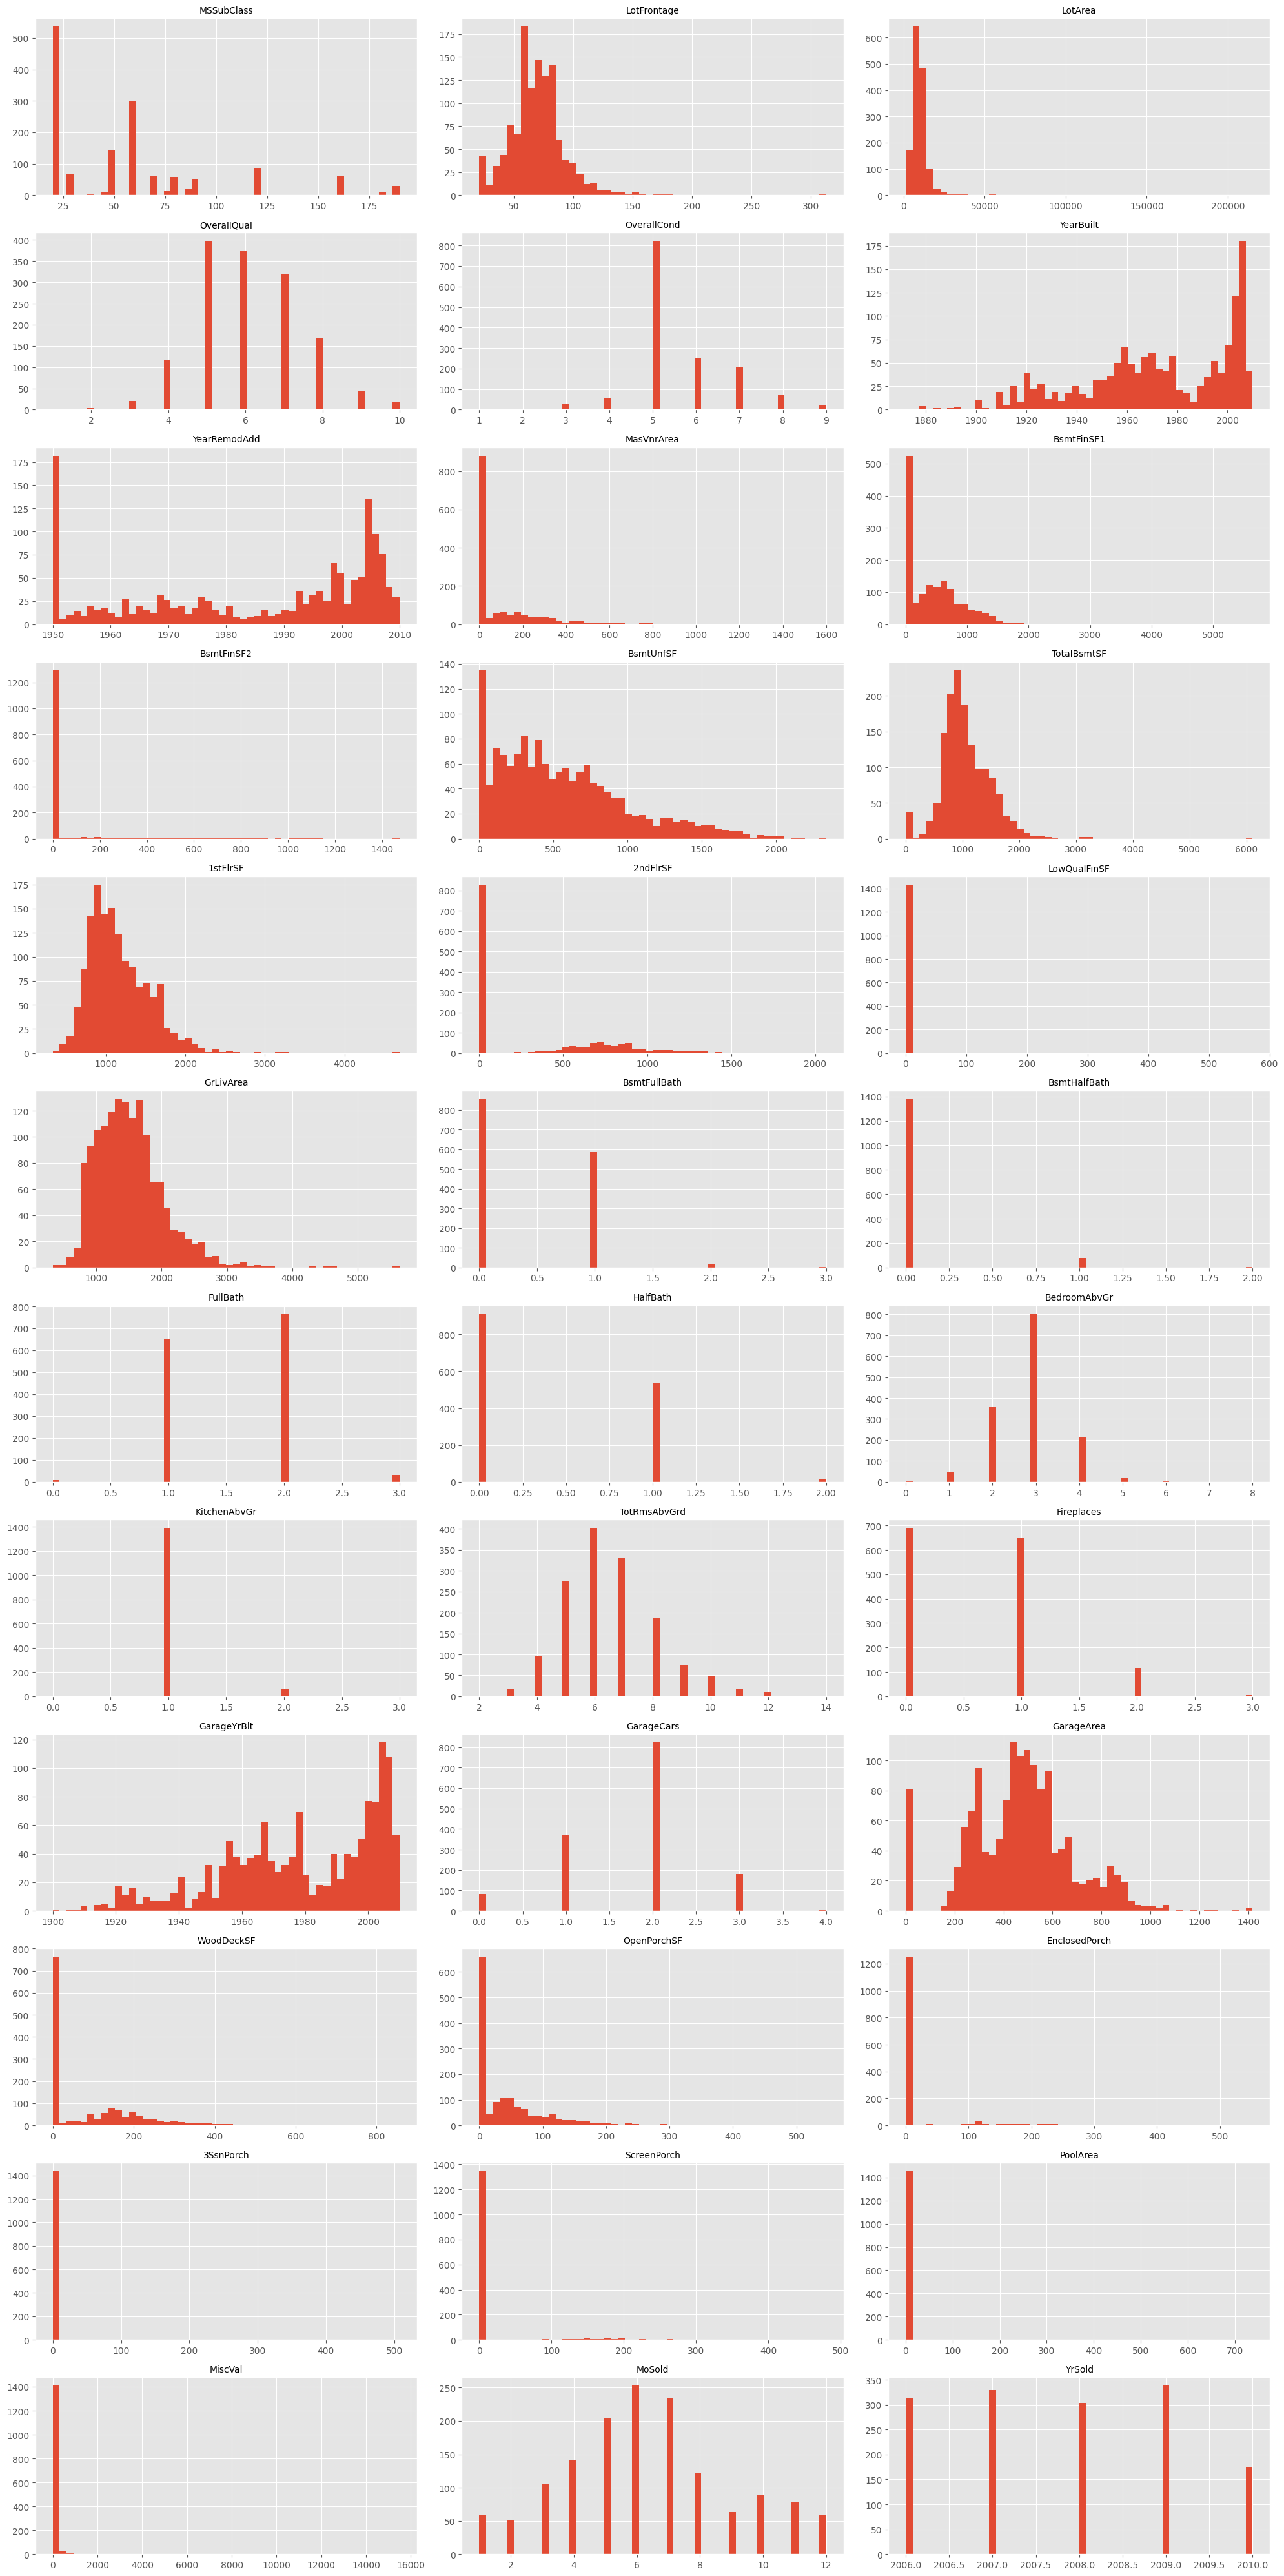

In [62]:
fig, ax = plt.subplots(12, 3, figsize=(20, 40))
ax = ax.ravel()

for i, col in enumerate(NUMERICAS):
    df[col].plot(kind='hist', bins=50, xlabel='', ylabel='', ax=ax[i])
    ax[i].set_title(col, fontsize=10)
    ax[i].tick_params(labelsize=10)

fig.tight_layout()
plt.show()

Así mismo, también se puede visualizar la distribución de las variables explicativas, en donde en la mayoría de ellas también se refleja un sesgo a la izquierda característico de las variables con valores no negativos. Así mismo, existen otras variables con distribuciones similares a la normal como el número de garajes por casa, y el año de remodelación. 

### Categoricas

In [56]:
CATEGORICAS = df.drop('SalePrice', axis=1).select_dtypes('object').columns.tolist()
len(CATEGORICAS)

43

Por su parte, existen 43 variables categóricas.

#### Estadisticas descriptivas

In [88]:
df[CATEGORICAS].describe().T.rename(columns={'unique': 'valores unicos', 'top': 'valor mas frecuente', 'freq': 'frecuencia valor mas frecuente'})

,count,valores unicos,valor mas frecuente,frecuencia valor mas frecuente
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


Podemos visualizar el número de etiquetas o valores únicos a tomar por cada variable categórica.

#### Distribucion

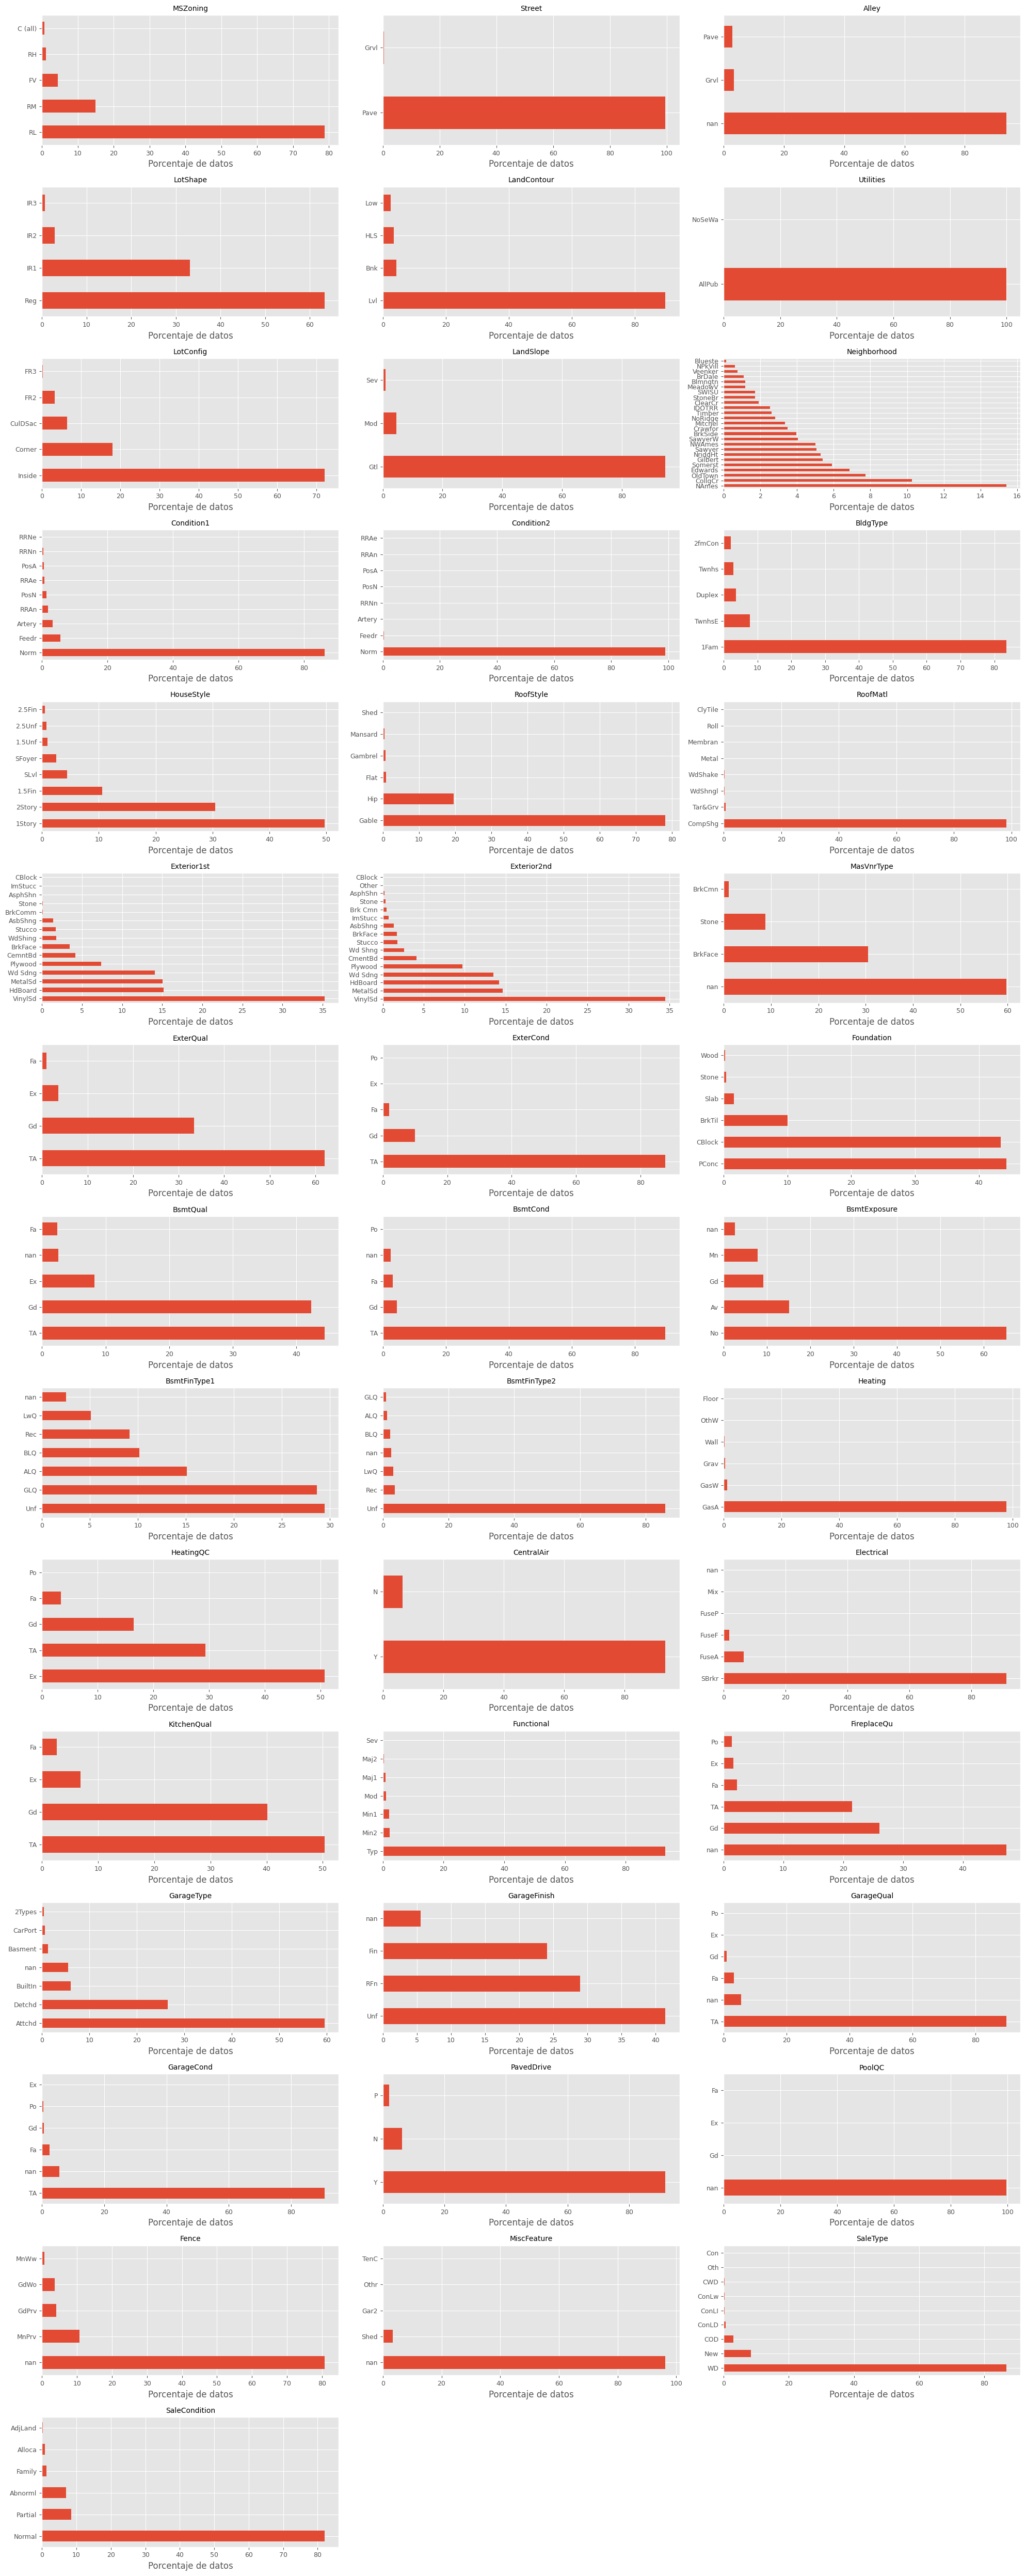

In [77]:
fig, ax = plt.subplots(15, 3, figsize=(20, 50))
ax = ax.ravel()

for i, col in enumerate(CATEGORICAS):
    (df[col].value_counts(normalize=True, dropna=False) * 100) \
        .plot(kind='barh', xlabel='Porcentaje de datos', ylabel='', ax=ax[i])
    ax[i].set_title(col, fontsize=10)
    ax[i].tick_params(labelsize=9)

for i in list(range(43, 45)):
    ax[i].axis('off')

fig.tight_layout()
plt.show()

Evidenciamos que la distribución de los datos está claramente sesgada en la mayoría de las variables, lo que es habitual en variables geográficos como el barrio dadas las diferencias en los ingresos según la ubicación. Barrios robustos equiparan la mayoría de los datos en ciudades distribuidos a partir de los ingresos percibidos por la población. ASí mismo, se identifica que las etiquetas caracterizadas como "convencionales" o "normales" como en la variable SaleCondition o SaleType recogen la mayoría de los datos y da cuenta justamente a la tendencia que tienen las etiquetas habituales a recoger la mayoría de los datos.

#### Distribucion de target por categorias

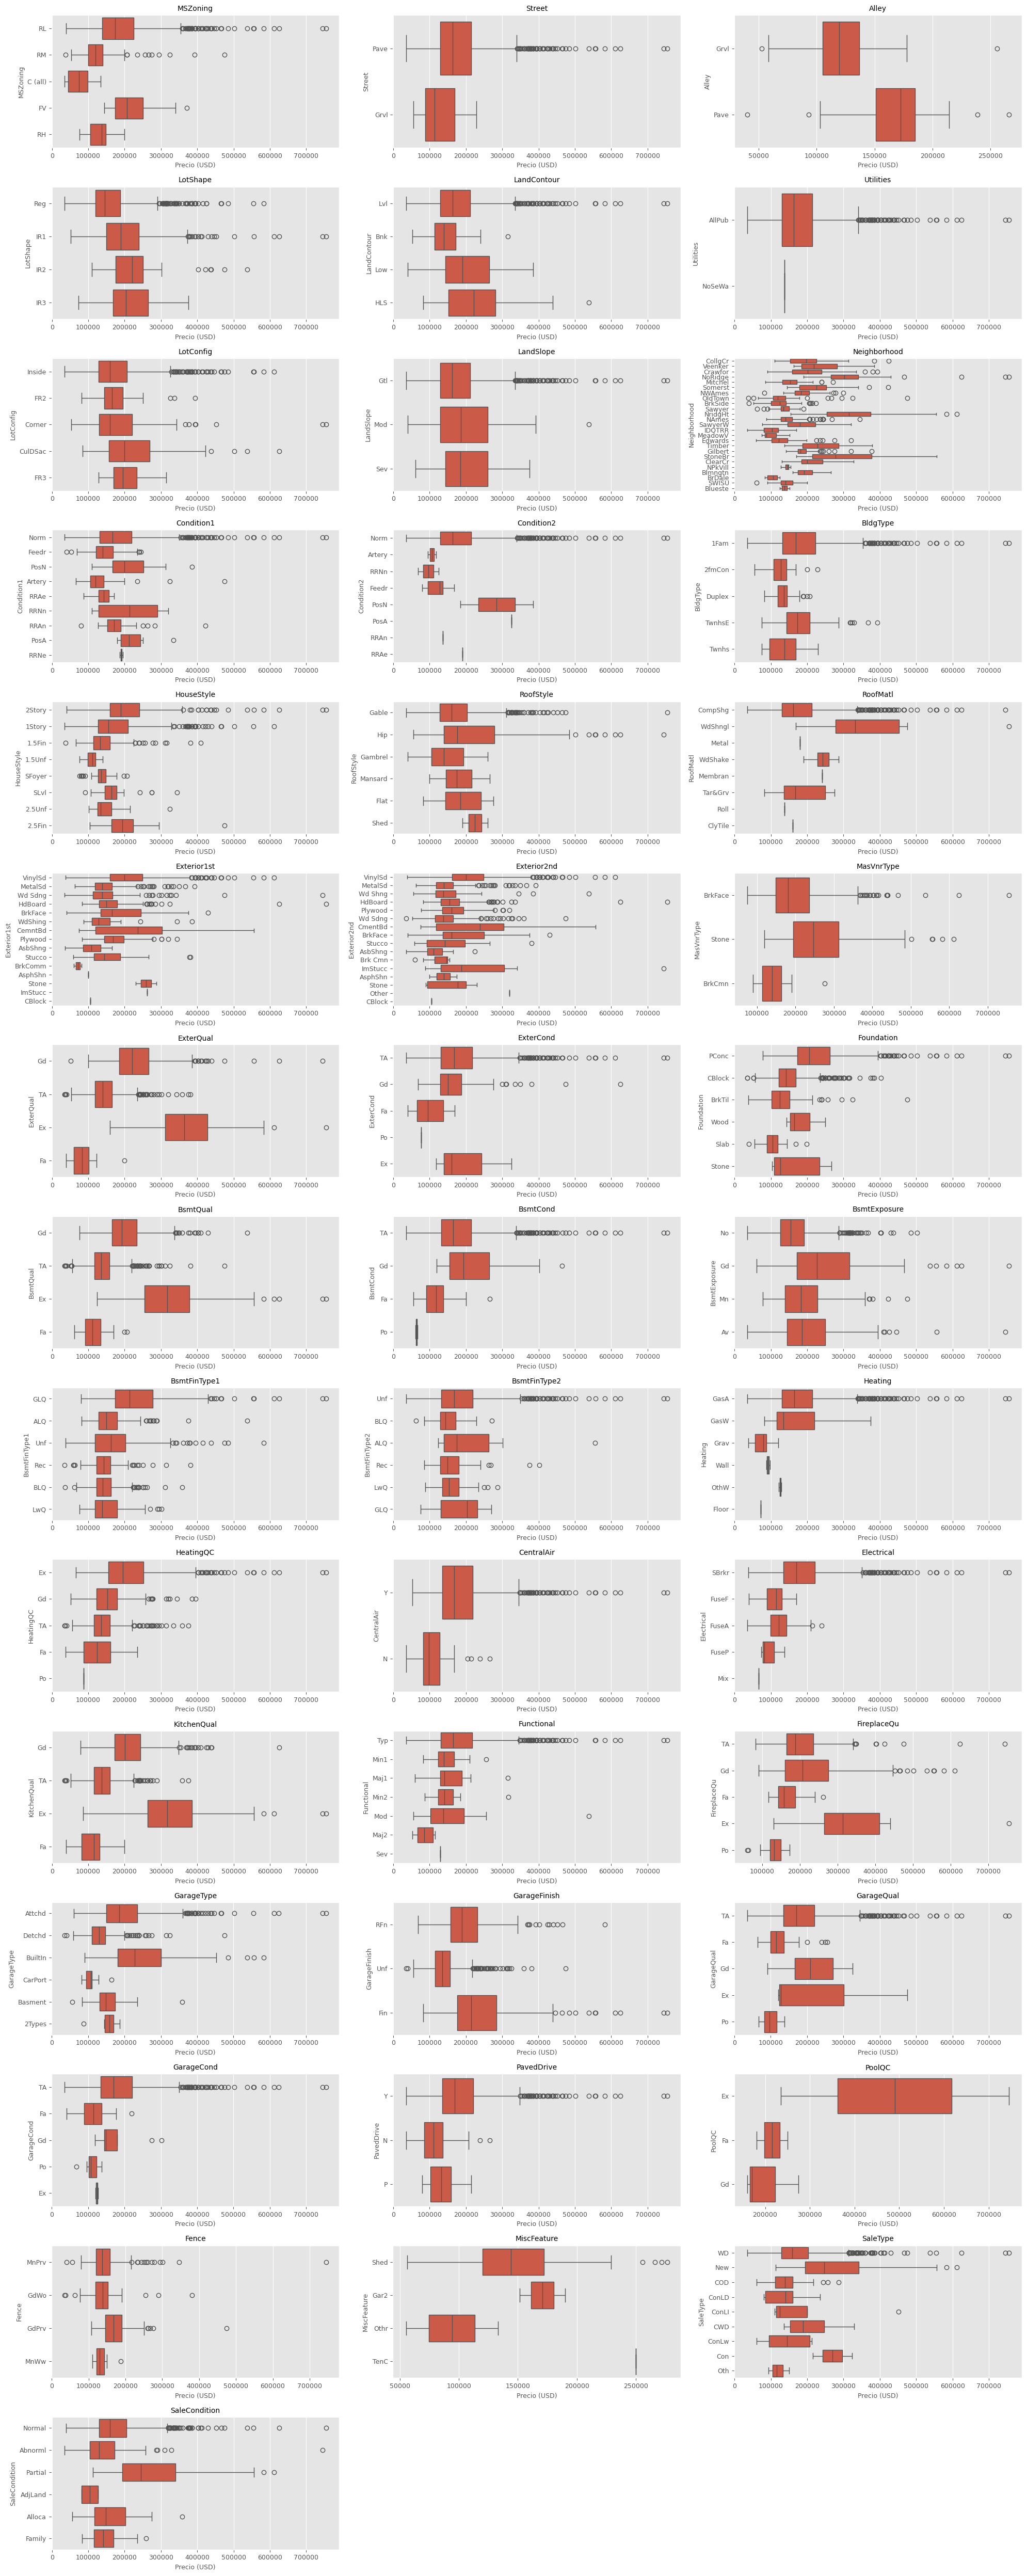

In [97]:
fig, ax = plt.subplots(15, 3, figsize=(20, 50))
ax = ax.ravel()

for i, col in enumerate(CATEGORICAS):
    sns.boxplot(y=col, x='SalePrice', data=df, ax=ax[i])
    ax[i].set_title(col, fontsize=10)
    ax[i].set_xlabel('Precio (USD)', fontsize=9)
    ax[i].set_ylabel(col, fontsize=9)
    ax[i].tick_params(labelsize=9)

for i in list(range(43, 45)):
    ax[i].axis('off')

fig.tight_layout()
plt.show()

Finalmente, con base en esta gráfica de cajas y bigotes aparte de que validamos nuevamente el sesgo que tienen la mayoría de las variables categóricas hacia uno de los lados, también observamos que la mayoría de variables cuentan con datos atípicos que habrá que tratar para el correcto funcionamiento de los modelos. Variables como SaleCondition, SaleType, GarageCond o Functional son prueba de ello.